In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

### Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [3]:
ratios = XY.loc[:, lbls].copy()

In [4]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)
#ratios

In [31]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = ratios.loc[ratios['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.5)
trainXY.shape

(36573, 15)

In [32]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

In [33]:
X, _, _, _, _, _ = splitXY(trainXY)

In [34]:
trainXY.sample(15)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
54050,phwr,4410.359403,0.711,2537.25,candu19,0.700325,0.000080,0.403043,0.001343,10.968661,5.628680,0.011525,0.040718,0.000976,0.000034
68511,phwr,3514.483206,0.711,5758.47,candu37,0.742215,0.000457,0.370629,0.002179,25.896007,14.698236,0.027925,0.111345,0.007821,0.000659
27906,pwr,3322.968797,3.740,2737.05,vver1000,0.754972,0.000576,0.331382,0.002279,7.275943,3.513561,0.022262,0.060367,0.006293,0.000235
48589,agr,5445.272476,3.630,6094.03,agr,0.658752,0.000171,0.693965,0.004248,26.251067,13.287788,0.021777,0.180289,0.025782,0.003881
27506,pwr,4442.878840,3.740,2273.61,vver1000,0.702256,0.000178,0.355733,0.002041,5.970571,2.839640,0.014908,0.050776,0.003824,0.000138
12025,pwr,0.000000,3.690,3991.11,ce14x14,1.011894,0.014901,0.261573,0.002240,17.042002,8.454870,0.065378,0.088202,0.020674,0.000736
54356,phwr,2288.898808,0.711,2864.32,candu19,0.800714,0.000565,0.351172,0.001412,11.777379,6.193896,0.020483,0.046279,0.001661,0.000050
32215,pwr,1376.296345,3.740,7553.51,vver1000,0.868421,0.008824,0.297388,0.004466,21.306478,10.745781,0.070711,0.142121,0.050169,0.004237
43976,agr,3759.913947,3.630,1865.75,agr,0.728467,0.000234,0.618235,0.001946,7.557466,3.297738,0.013541,0.060610,0.003520,0.000118
61166,phwr,364.367618,0.711,9974.16,candu19,0.907016,0.011591,0.288416,0.003052,47.760618,28.252896,0.082722,0.180751,0.028656,0.002970


In [35]:
# Choosing PHWR sample intentionally
sim_idx = 65332
test_exist = trainXY_phwr.loc[trainXY_phwr.index == sim_idx]
test_exist

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239,LogLikelihood


In [36]:
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
65332,phwr,1885.822793,0.711,3383.22,candu37


In [37]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [38]:
unc = 0.07
#uncs = [0.07, 0.14, 0.28]
#for unc in uncs:
#    ll_name = 'LogLikelihood_' + str(unc)
#    unc_name = 'LLUncertainty_' + str(unc)
#    trainXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
#    trainXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [39]:
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)

In [40]:
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()

In [63]:
medall = trainXY['LogLikelihood'].median()
medpwr = trainXY_pwr['LogLikelihood'].median()
medagr = trainXY_agr['LogLikelihood'].median()
medphwr = trainXY_phwr['LogLikelihood'].median()
statall = stats.describe(trainXY['LogLikelihood'])
statpwr = stats.describe(trainXY_pwr['LogLikelihood'])
statagr = stats.describe(trainXY_agr['LogLikelihood'])
statphwr = stats.describe(trainXY_phwr['LogLikelihood'])
print(f'All Median: {medall} Stats: {statall} \n')
print(f'PWR Median: {medpwr} Stats: {statpwr} \n')
print(f'AGR Median: {medagr} Stats: {statagr} \n')
print(f'PHWR Median: {medphwr} Stats: {statphwr} \n')

All Median: -355.45372278521836 Stats: DescribeResult(nobs=36573, minmax=(-125633278.77893184, 48.291245195700085), mean=-811074.8828603174, variance=52866151409985.65, skewness=-9.756756310859943, kurtosis=98.7319845371911) 

PWR Median: -334.5889987551298 Stats: DescribeResult(nobs=17036, minmax=(-939258.272693406, -124.90156162595052), mean=-4130.554276936937, variance=752979840.9790297, skewness=-20.291310275707318, kurtosis=514.3945255143641) 

AGR Median: -383.6850622596191 Stats: DescribeResult(nobs=8517, minmax=(-343234.6431850004, -100.16585796504086), mean=-2562.5251862107034, variance=133093102.91928117, skewness=-13.28644583583535, kurtosis=255.41488466839843) 

PHWR Median: -376.5520236375824 Stats: DescribeResult(nobs=11020, minmax=(-125633278.77893184, 48.291245195700085), mean=-2683416.3830469633, variance=170443223708058.66, skewness=-5.161337390283352, kurtosis=26.40047844424481) 



In [64]:
plotXY1 = trainXY_pwr.loc[trainXY_pwr['LogLikelihood'] > medpwr]
plotXY2 = trainXY_agr.loc[trainXY_agr['LogLikelihood'] > medagr]
plotXY3 = trainXY_phwr.loc[trainXY_phwr['LogLikelihood'] > medphwr]
plotXY4 = trainXY.loc[trainXY['LogLikelihood'] > medall]

In [75]:
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']
plots = [plotXY1, plotXY2, plotXY3, plotXY4]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'AxesSubplot' object has no attribute 'plot_trisurf'

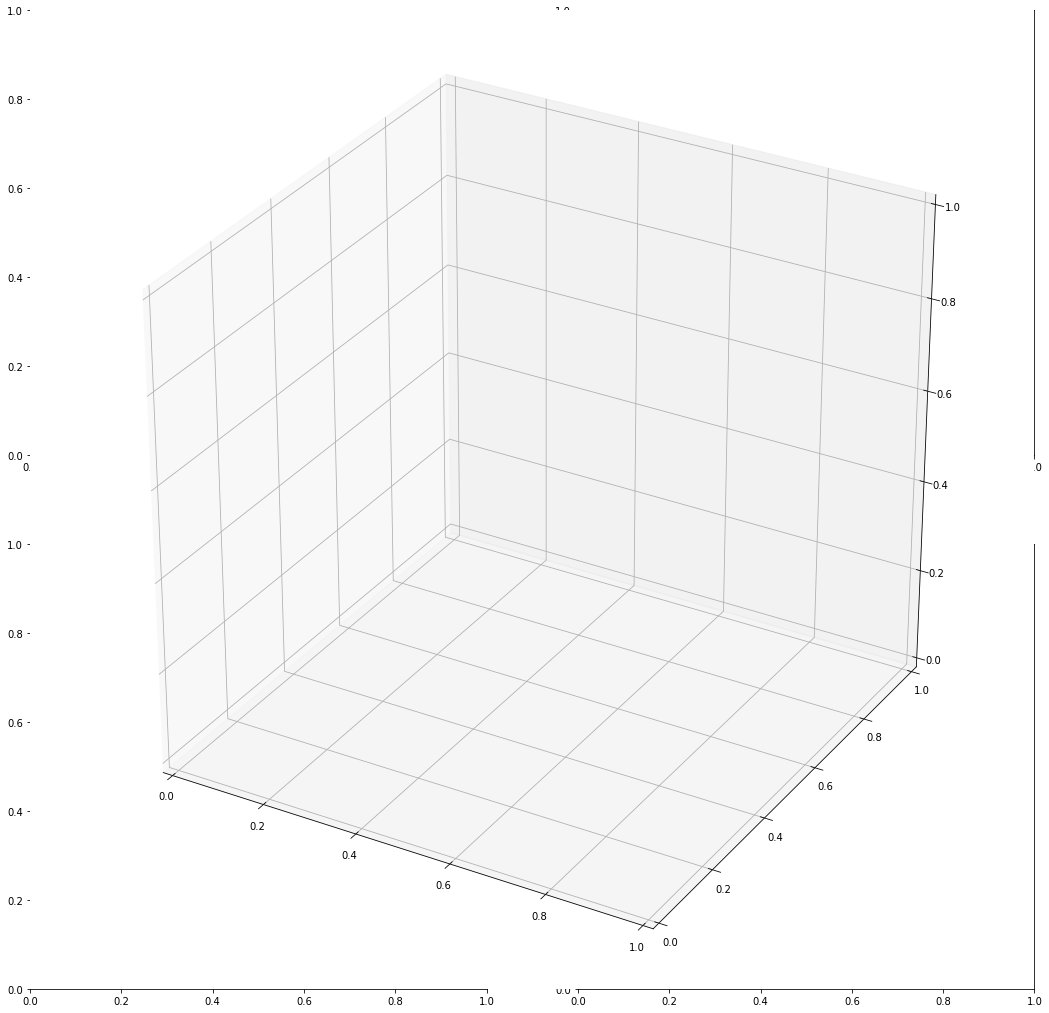

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))
#fig.suptitle('LL wrt Burnup and Cooling Time for 3 Reactor Types')
fig.gca(projection='3d')

surfs = []
for i, (ax, plotXY) in enumerate(zip(axes.flat, plots)):
    x = plotXY['Burnup']
    y = plotXY['CoolingTime']
    triang = tri.Triangulation(x, y)
    z = plotXY['LogLikelihood']
    surf = ax.plot_trisurf(triang, z, linewidth=0.1, cmap='jet')
    surfs.append(surf)
    ax.set_title(rxtrs[i])
    ax.set_xlabel('Burnup [MWd/MTHM]')
    ax.set_ylabel('Cooling Time [days]')
    ax.set_zlabel('Log Likelihood')
    ax.set_xlim(0, 10000)
    ax.set_zlim(medagr, 50)

cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
fig.colorbar(surfs[2], cax=cbar_ax, shrink=0.3, aspect=15)#, location='right')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)
    
    def predict(self, nuc_list):
        
        return burn

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(14629, 11)

In [24]:
X

,const,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
53806,1.0,0.823392,0.000721,0.342803,0.001343,10.968661,5.628680,0.020296,0.040731,0.001372,3.431042e-05
28420,1.0,0.749728,0.000705,0.335512,0.002772,10.612981,5.221154,0.027415,0.080265,0.010929,5.689857e-04
61655,1.0,0.913999,0.013757,0.284238,0.003233,54.132357,32.032124,0.088586,0.195413,0.033621,3.776233e-03
54166,1.0,0.898284,0.002690,0.313029,0.001412,11.777379,6.193896,0.030624,0.046300,0.002115,5.029059e-05
729,1.0,0.806251,0.000714,0.297304,0.001567,4.238126,1.985237,0.017304,0.036391,0.002463,4.720175e-05
27384,1.0,0.761687,0.000536,0.327977,0.002041,5.970571,2.839640,0.019812,0.050784,0.004537,1.376314e-04
62475,1.0,0.749282,0.000023,0.401342,0.000911,1.344025,0.713399,0.002719,0.006795,0.000037,1.943396e-07
686,1.0,0.828607,0.001036,0.289283,0.001567,4.238126,1.985237,0.019040,0.036408,0.002608,4.718886e-05
66783,1.0,0.847470,0.002108,0.328358,0.001862,19.971751,11.026365,0.036554,0.084623,0.006106,2.880040e-04
53676,1.0,0.892788,0.002162,0.316157,0.001343,10.968661,5.628680,0.026941,0.040748,0.001627,3.431042e-05


In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 545458.327359
         Iterations: 1704
         Function evaluations: 2503
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -7.9795e+09
Model:                        NormMod   AIC:                         1.596e+10
Method:            Maximum Likelihood   BIC:                         1.596e+10
Date:                Mon, 26 Aug 2019                                         
Time:                        12:39:45                                         
No. Observations:               14629                                         
Df Residuals:                   14618                                         
Df Model:                          10                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
res.params

array([ 152.78657995,  573.3246519 ,    9.28999576,  296.89667871,
       -466.11324286,  578.71779207, -664.32524069, -397.83215989,
        170.26901221, -109.53584399, -515.51328671])

In [28]:
test_sample.insert(0, 'const', 1.0)

In [29]:
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(2692.582140167781, 43552    1604.81
 Name: Burnup, dtype: float64)